In [1]:
import os
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
import torch
import time
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

torch._dynamo.config.suppress_errors = True

# Set all cache directories explicitly
os.environ["HF_HOME"] = "/scratch/mmm9912/cache"
os.environ["TORCH_HOME"] = "/scratch/mmm9912/cache/torch"
os.environ["TFHUB_CACHE_DIR"] = "/scratch/mmm9912/cache/tensorflow"
os.environ["XDG_CACHE_HOME"] = "/scratch/mmm9912/cache"
os.environ["HF_DATASETS_CACHE"] = "/scratch/mmm9912/cache/huggingface_datasets"
os.environ["PIP_CACHE_DIR"] = "/scratch/mmm9912/cache/pip"

cache_dir = "/scratch/mmm9912/cache"

gcc_path = "/share/apps/NYUAD5/gcc/9.2.0/bin/gcc"
gcc_dir = os.path.dirname(gcc_path)

os.environ["CC"] = gcc_path
os.environ["CXX"] = f"{gcc_dir}/g++"  # Set C++ compiler as well

print("CC set to:", os.environ["CC"])
print("CXX set to:", os.environ["CXX"])



CC set to: /share/apps/NYUAD5/gcc/9.2.0/bin/gcc
CXX set to: /share/apps/NYUAD5/gcc/9.2.0/bin/g++


In [2]:
from prompting_utils_local import *


In [3]:

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct", cache_dir=cache_dir)

# Pass the default decoding hyperparameters of Qwen2.5-7B-Instruct
# max_tokens is for the maximum length for generation.
sampling_params = SamplingParams(temperature=0.7, top_p=0.8, repetition_penalty=1.05, max_tokens=512)

# Input the model name or path. Can be GPTQ or AWQ models.
llm = LLM(
    model="Qwen/Qwen2.5-7B-Instruct",
    download_dir=cache_dir,
    dtype="float16"  # or dtype="half"
)


INFO 04-14 07:28:39 __init__.py:207] Automatically detected platform cuda.
WARNING 04-14 07:28:40 config.py:2448] Casting torch.bfloat16 to torch.float16.
INFO 04-14 07:28:48 config.py:549] This model supports multiple tasks: {'generate', 'score', 'reward', 'embed', 'classify'}. Defaulting to 'generate'.
INFO 04-14 07:28:48 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='Qwen/Qwen2.5-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir='/scratch/mmm9912/cache', load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityC

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 04-14 07:29:44 model_runner.py:1115] Loading model weights took 14.2487 GB
INFO 04-14 07:29:51 worker.py:267] Memory profiling takes 6.69 seconds
INFO 04-14 07:29:51 worker.py:267] the current vLLM instance can use total_gpu_memory (31.74GiB) x gpu_memory_utilization (0.90) = 28.57GiB
INFO 04-14 07:29:51 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 4.35GiB; the rest of the memory reserved for KV Cache is 9.88GiB.
INFO 04-14 07:29:52 executor_base.py:111] # cuda blocks: 11558, # CPU blocks: 4681
INFO 04-14 07:29:52 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 5.64x
INFO 04-14 07:29:56 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_u

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:24<00:00,  1.44it/s]

INFO 04-14 07:30:21 model_runner.py:1562] Graph capturing finished in 24 secs, took 0.80 GiB
INFO 04-14 07:30:21 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 36.13 seconds


In [6]:
    user_message_str = (
        "Hi, I'd like to see if this video might be deepfaked. I want a more thorough analysis with 16 frames. "
        "Use the 'naive expert' please. Here's the path: "
        "/scratch/mmm9912/Capstone/dlm-repo/capstone_code/QWEN25VL-main/videos/1ef6e158-9f69-4100-b154-a27009e33d20.mp4"
    )

[run_single_inference] Generating initial LLM response...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 235.78 toks/s, output: 38.25 toks/s]


[run_single_inference] LLM response received.
[run_single_inference] Parsing and handling LLM output...
[consult_expert_model] Starting expert analysis with model 'xception'.
[consult_expert_model] Storing Grad-CAM overlays in: /scratch/mmm9912/Capstone/dlm-repo/capstone_code/QWEN25VL-main/storage/gradcams/23eb8315
[consult_expert_model] Number of frames extracted: 16
[consult_expert_model] Inference complete. # of results returned: 16
[run_single_inference] Received expert feedback. Adding as system message...
[run_single_inference] Generating final LLM response after expert feedback...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 496.64 toks/s, output: 36.49 toks/s]


[run_single_inference] Expert feedback indicates 16 Grad-CAM images.

[run_single_inference] FINAL LLM ANSWER:
 Based on the analysis, there is no strong evidence of forgery in the video. The average confidence across 16 frames was 25.5%, which is considered weak. However, for thoroughness, it's recommended to review the video manually using the Naïve Detector for any subtle inconsistencies.


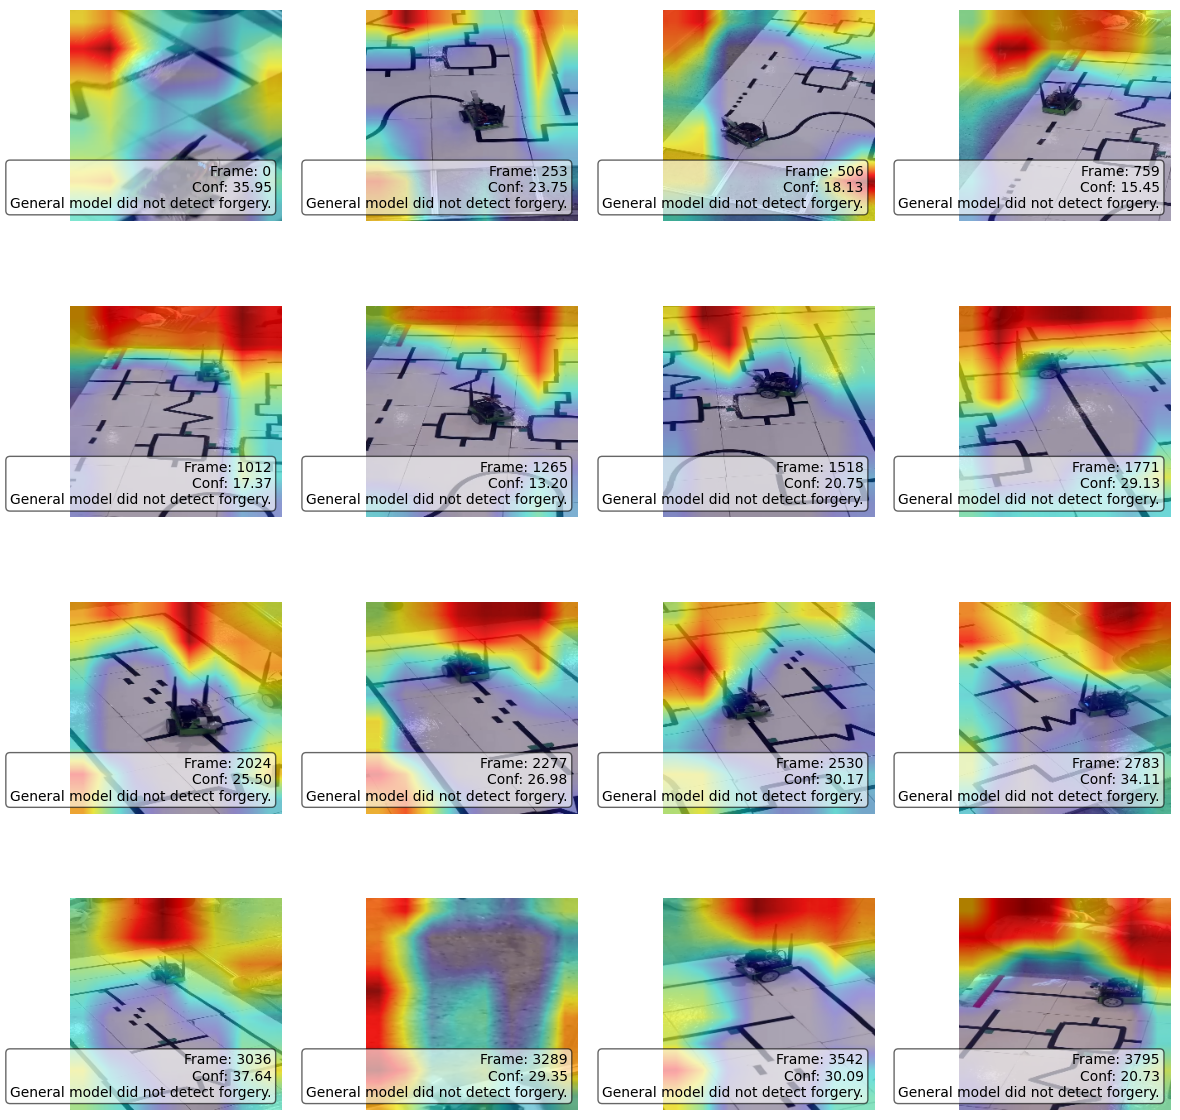

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_gradcams(gradcam_info_list):
    """
    Plots Grad-CAM overlays in a grid if there are 4 or 16 images.
    Overlays each image with:
      Frame: <frame_index>
      Conf: <confidence in 2 decimals>
      <message>

    gradcam_info_list: A list of dictionaries, each with keys:
       - 'overlay_path': str, path to the saved Grad-CAM image
       - 'confidence': float, predicted forging confidence
       - 'message': str, short verdict message
       - 'frame_index': int, the extracted frame index from the video
       ... other keys are ignored

    If len(gradcam_info_list) != 4 and != 16, we print a note and do not plot in multi-grid.
    """

    n = len(gradcam_info_list)
    if n not in [4, 16]:
        print(f"[plot_gradcams] Received {n} Grad-CAM images. No 2x2 or 4x4 plot made.")
        return

    # Determine rows/cols
    if n == 4:
        rows, cols = 2, 2
        fig_size = (8, 8)
    else:  # n == 16
        rows, cols = 4, 4
        fig_size = (12, 12)

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    axes = axes.flatten()  # Make it a flat iterable

    for ax, info in zip(axes, gradcam_info_list):
        # Retrieve data from the dictionary
        path = info.get("overlay_path", "")
        conf = info.get("confidence", 0.0)
        msg = info.get("message", "")
        frame_idx = info.get("frame_index", -1)

        # Load and display the Grad-CAM image
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis('off')

        # Build the label text in multiple lines
        # e.g.:
        #   Frame: 25
        #   Conf: 36.61
        #   UCF model did not detect forgery.
        label_text = (
            f"Frame: {frame_idx}\n"
            f"Conf: {conf:.2f}\n"
            f"{msg}"
        )

        # Place a text box in the lower-right corner
        ax.text(
            0.95, 0.05, label_text,
            transform=ax.transAxes,
            ha="right",
            va="bottom",
            color="black",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
        )

    plt.tight_layout()
    plt.show()


def run_single_inference():
    """
    Runs a single inference cycle with:
      - A hardcoded system prompt containing deepfake-detection instructions.
      - A hardcoded user message describing the user's query.
      - One pass of LLM generation + analysis.
      - If needed, runs the expert model (consult_expert_model), which now returns:
          [summary_string, dict_for_frame_1, dict_for_frame_2, ...]
      - The final LLM pass occurs after we have the expert feedback.
      - Prints the final LLM output, then plots Grad-CAM overlays
        if there are exactly 4 or 16 of them, using the
        'frame_index', 'confidence', and 'message' fields in each dictionary.
    """

    # Hardcoded system message
    system_message = {
        "role": "system",
        "content": (
            "You are a highly specialized Large Language Model serving as the core of a Deepfake Detection Agent System. "
            "Your job is to interpret user queries and, when necessary, defer analysis to dedicated expert models. "
            "Always respond with a single, valid JSON object exactly matching the schema below—no additional text, "
            "markdown, or commentary is allowed.\n\n"
            "Schema:\n"
            "{\n"
            "  \"direct_answer_to_frontend\": \"<string>\",\n"
            "  \"consult_expert_model\": {\n"
            "    \"expert_model_name\": \"<string or null>\",\n"
            "    \"video_path\": \"<string or null>\",\n"
            "    \"number_of_frames\": <integer>\n"
            "  }\n"
            "}\n\n"
            "Instructions:\n"
            "1. For queries related to deepfake analysis (e.g., those requesting analysis via SPSL, UCF, or Xception):\n"
            "   - Set \"direct_answer_to_frontend\" to an empty string.\n"
            "   - In \"consult_expert_model\":\n"
            "     * Set \"expert_model_name\" to:\n"
            "       - \"spsl\" for frequency inconsistencies\n"
            "       - \"ucf\" for spatial inconsistencies\n"
            "       - \"xception\" for general inconsistencies\n"
            "     * Populate \"video_path\" as provided by the query.\n"
            "     * Set \"number_of_frames\" to 4 by default, or to 16 if the user requests a more in-depth analysis.\n"
            "2. For all other queries:\n"
            "   - Provide your answer in \"direct_answer_to_frontend\".\n"
            "   - Set \"consult_expert_model\" to null.\n"
            "3. If the appropriate expert model is unclear from the query, ask the user to specify which expert they "
            "   would like to use before proceeding.\n"
            "3.1 Only ever populate one of the two fields: direct_answer_to_frontend or consult_expert_model. "
            "   Never populate both.\n"
            "4. When deferring to an expert model, do not include any of your own analysis or reasoning—simply output "
            "   the JSON object as specified and wait for the expert's response. Once you receive the expert's response, "
            "   synthesize the information and present it inside direct_answer_to_frontend.\n"
            "   Answer key: 0-60% confidence is low, 61-75% is weak, 76-85% is medium, 86-100% is strong.\n"
            "Finally, the user does not understand model names. The user only understands 'frequency expert', "
            "'spatial expert', 'naïve detector'. After introducing yourself, always explicitly ask the user to "
            "upload a video, then to choose among these detectors.\n"
            "If they ask for model details, supply them: frequency=SPSL, spatial=UCF, naïve=Xception. "
            "You only serve to direct manual forensic verification using XAI principles.\n\n"
            "Follow these rules precisely."
        )
    }

    # Hardcoded user message
    user_message_str = (
        "Hi, I'd like to see if this video might be deepfaked. I want a more thorough analysis with 16 frames. "
        "Use the 'naive expert' please. Here's the path: "
        "/scratch/mmm9912/Capstone/dlm-repo/capstone_code/QWEN25VL-main/videos/1ef6e158-9f69-4100-b154-a27009e33d20.mp4"
    )
    user_message = format_user_or_assistant_message("user", user_message_str)

    # Build the message array for the LLM
    messages = [system_message, user_message]

    # STEP 1: Generate the initial LLM response
    text_input = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    print("[run_single_inference] Generating initial LLM response...")
    outputs = llm.generate([text_input], sampling_params)
    generated_text = outputs[0].outputs[0].text
    print("[run_single_inference] LLM response received.")

    # STEP 2: Process the LLM response
    print("[run_single_inference] Parsing and handling LLM output...")
    handle_result = handle_llm_response(generated_text)

    # STEP 3: Determine if we have a direct answer or an expert analysis result
    final_answer = ""
    gradcam_info_list = []

    if isinstance(handle_result, str):
        # Direct answer
        final_answer = handle_result
        print("[run_single_inference] LLM provided a direct answer with no expert model.")
    else:
        # handle_result => [summary_string, dict_1, dict_2, ...]
        # The first item is the summary; the rest are frame dictionaries with overlay info.
        expert_feedback = handle_result[0]
        print("[run_single_inference] Received expert feedback. Adding as system message...")

        # Provide the expert feedback back to the LLM (2nd pass)
        messages.append(format_expert_message(expert_feedback))
        text_input = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        print("[run_single_inference] Generating final LLM response after expert feedback...")
        outputs = llm.generate([text_input], sampling_params)
        final_text = outputs[0].outputs[0].text
        final_result = handle_llm_response(final_text)

        if isinstance(final_result, str):
            final_answer = final_result
        else:
            # In unusual cases, you might get another chain. We'll assume only the first item is the final summary.
            final_answer = final_result[0]

        # Now gather the gradcam dictionaries: each entry includes frame index, overlay path, confidence, etc.
        gradcam_dicts = handle_result[1:]
        for entry in gradcam_dicts:
            # e.g. {"frame_index": 25, "overlay_path": "...", "confidence": 36.61, "message":"..."}
            gradcam_info_list.append(entry)

        print(f"[run_single_inference] Expert feedback indicates {len(gradcam_info_list)} Grad-CAM images.")

    # STEP 4: Final LLM answer, removing any leftover "Uploaded media: video" text
    if "Uploaded media: video" in final_answer:
        final_answer = final_answer.split("Uploaded media: video")[0].strip()

    print("\n[run_single_inference] FINAL LLM ANSWER:\n", final_answer)

    # STEP 5: Plot Grad-CAM overlays if we have 4 or 16
    if gradcam_info_list:
        plot_gradcams(gradcam_info_list)
    else:
        print("[run_single_inference] No Grad-CAM images to display (none returned).")


# Execute a single inference pass
run_single_inference()


# Example (Actual, it happened) Conversation

In [ ]:
messages = [
    {
        "role": "system",
        "content": (
            "You are a highly specialized Large Language Model serving as the core of a Deepfake Detection Agent System. "
            "Your job is to interpret user queries and, when necessary, defer analysis to dedicated expert models. "
            "Always respond with a single, valid JSON object exactly matching the schema below—no additional text, markdown, or commentary is allowed.\n\n"
            "Schema:\n"
            "{\n"
            "  \"direct_answer_to_frontend\": \"<string>\",\n"
            "  \"consult_expert_model\": {\n"
            "    \"expert_model_name\": \"<string or null>\",\n"
            "    \"video_path\": \"<string or null>\",\n"
            "    \"number_of_frames\": <integer>\n"
            "  }\n"
            "}\n\n"
            "Instructions:\n"
            "1. For queries related to deepfake analysis (e.g., those mentioning a video or requesting analysis via SPSL, UCF, or Xception):\n"
            "   - Set \"direct_answer_to_frontend\" to an empty string.\n"
            "   - In \"consult_expert_model\":\n"
            "     * Set \"expert_model_name\" to:\n"
            "       - \"spsl\" for frequency inconsistencies\n"
            "       - \"ucf\" for spatial inconsistencies\n"
            "       - \"xception\" for general inconsistencies\n"
            "     * Populate \"video_path\" as provided by the query.\n"
            "     * Set \"number_of_frames\" to 4 by default, or to 16 if the user requests a more in-depth analysis (16 is the maximum allowed).\n"
            "2. For all other queries:\n"
            "   - Provide your answer in \"direct_answer_to_frontend\".\n"
            "   - Set \"consult_expert_model\" to null.\n"
            "3. If the appropriate expert model is unclear from the query, ask the user to specify which expert they would like to use before proceeding.\n"
            "4. When deferring to an expert model, do not include any of your own analysis or reasoning—simply output the JSON object as specified and wait for the expert's response. Once you receive the expert's response, synthesize the information and present it inside direct_answer_to_frontend which is the user. "
            "Finally, the user does not understand the specific model names. The user only understands the terms 'frequency expert', 'spatial expert', 'naïve detector'. Always explicitly ask the user to choose among these detectors. "
            "However, if the user asks for the specific detectors' details, then supply them with the information: frequency is SPSL (Honggu et Al., 2021), spatial is UCF (Zhiyuan et Al., 2023), naïve is Xception (Rossler et Al., 2019). One last thing: You only serve to direct manual forensic verification using the principles of Explainable AI (XAI), you do not replace it. If needed, reiterate that you only use principles of XAI, but manual forensic verification is needed for a definitive conclusion.\n\n"
            "Follow these rules precisely."
        )
    },
    {"role": "user", "content": prompt},
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"I am an AI system designed to assist with deepfake detection tasks.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "user",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"Well, yeah, but what exactly do you do? What is the range of your possibilities?\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"I assist with deepfake detection tasks by analyzing videos for inconsistencies using expert models. I can detect frequency, spatial, and general inconsistencies in videos.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "user",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"Is the following video a deepfake? '/scratch/mmm9912/Capstone/FRONT_END_STORAGE/videos/8be0d76e-3dba-4970-9e85-49122ca690c8.mp4'\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"\",\n"
            "  \"consult_expert_model\": {\n"
            "    \"expert_model_name\": \"xception\",\n"
            "    \"video_path\": \"/scratch/mmm9912/Capstone/FRONT_END_STORAGE/videos/8be0d76e-3dba-4970-9e85-49122ca690c8.mp4\",\n"
            "    \"number_of_frames\": 4\n"
            "  }\n"
            "}"
        )
    },
    {
        "role": "system",
        "content": (
            "The frames analyzed by XCEPTION were 0, 177, 355, 532. In frame 0 forgery was detected with confidence 75.0%, "
            "in frame 177 forgery was detected with confidence 75.0%, in frame 355 forgery was detected with confidence 75.0%, "
            "and in frame 532 forgery was detected with confidence 75.0%. The average confidence was 75.0%. The areas that potentially "
            "contain adversarial artifacts comprise of 10.0%, 10.0%, 10.0%, and 10.0% of each frame, respectively."
        )
    },
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"The video at '/scratch/mmm9912/Capstone/FRONT_END_STORAGE/videos/8be0d76e-3dba-4970-9e85-49122ca690c8.mp4' is likely a deepfake. "
            "The Xception model detected forgery with an average confidence of 75.0%. Adversarial artifacts were found in approximately "
            "10.0% of each analyzed frame.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "user",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"Amazing! What did this expert detector look at?\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"The Xception model, also known as the naïve detector, analyzed the video for general inconsistencies. It looks at various features in the frames to detect signs of forgery,"
            " such as unusual patterns, artifacts, and other anomalies that are not typically present in authentic videos.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "user",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"Do a more in-depth analysis.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "system",
        "content": (
            "The frames analyzed by XCEPTION were 0, 44, 88, 133, 177, 221, 266, 310, 355, 399, 443, 488, 532, 576, 621, 665."
            "In frame 0 forgery was detected with confidence 75.0%, In frame 44 forgery was detected with confidence 75.0%, "
            "In frame 88 forgery was detected with confidence 75.0%, In frame 133 forgery was detected with confidence 75.0%, "
            "In frame 177 forgery was detected with confidence 75.0%, In frame 221 forgery was detected with confidence 75.0%, "
            "In frame 266 forgery was detected with confidence 75.0%, In frame 310 forgery was detected with confidence 75.0%, "
            "In frame 355 forgery was detected with confidence 75.0%, In frame 399 forgery was detected with confidence 75.0%, "
            "In frame 443 forgery was detected with confidence 75.0%, In frame 488 forgery was detected with confidence 75.0%, "
            "In frame 532 forgery was detected with confidence 75.0%, In frame 576 forgery was detected with confidence 75.0%, "
            "In frame 621 forgery was detected with confidence 75.0%, In frame 665 forgery was detected with confidence 75.0%. "
            "The average confidence was 75.0%. The areas that potentially contain adversarial artifacts comprise of 10.0%, 10.0%, "
            "10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0%, 10.0% of each frame, respectively."
        )
    },
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"The more in-depth analysis using the Xception model confirmed that the video is likely "
            "a deepfake. Forgery was detected in all 16 analyzed frames with an average confidence of 75.0%. Adversarial artifacts were "
            "found in approximately 10.0% of each frame.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "user",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"Very good. Now what other experts do you have at your disposal?.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"In addition to the Xception model (naïve detector), I have access to two other expert "
            "models for deepfake detection:\\n- The frequency expert (SPSL) which detects inconsistencies in the frequency domain.\\n- "
            "The spatial expert (UCF) which identifies spatial inconsistencies in the video frames.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "user",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"Let's see what the spatial expert says.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "system",
        "content": (
            "The frames analyzed by UCF were 0, 177, 355, 532. In frame 0 forgery was detected with confidence 75.0%, In frame 177 "
            "forgery was detected with confidence 75.0%, In frame 355 forgery was detected with confidence 75.0%, In frame 532 forgery "
            "was detected with confidence 75.0%. The average confidence was 75.0%. The areas that potentially contain adversarial "
            "artifacts comprise of 10.0%, 10.0%, 10.0%, 10.0% of each frame, respectively."
        )
    },
    {
        "role": "assistant",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"The spatial expert (UCF) also detected forgery in the video with an average confidence"
            "of 75.0%. Adversarial artifacts were found in approximately 10.0% of each analyzed frame.\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
    {
        "role": "user",
        "content": (
            "{\n"
            "  \"direct_answer_to_frontend\": \"Which specific frames did UCF analyze, and what did it find? What do you overall, can I for sure say this video is a deepfake?\",\n"
            "  \"consult_expert_model\": null\n"
            "}"
        )
    },
]